# XGBoost

The goal of this notebook is to provide a quick demonstration of XGBoost in conjunction with "traditional" sklearn processes.

In [1]:
import multiprocessing
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

import xgboost as xgb

We will play with the [eye movements dataset](https://www.openml.org/search?type=data&sort=runs&id=1044&status=active) from openml.

It contains various eye movements metrics measured as participants scan a list of news titles.

The setup is that participants are given a question, and then are presented 10 news titles. 5 are irrelevant to the question asked, 4 are relevant but do not answer the question, and 1 is relevant and answers the question.

The original data presents the eye movements metrics for each single words in the titles, for the sake of simplifying the data structure (which should normaly account for dependency between words in the same title and so on), we have aggregated the words by title for each assignment (we used a mean aggregation).


The target is encoded as:
 * 0 : title irrelevant
 * 1 : title relevant but does not answer the question
 * 2 : title relevant and answers the question

The features are:
 * **fixcount Number of fixations to the word 
 * **firstPassCnt** Number of fixations to the word when it is first encountered 
 * **P1stFixation** '1' if fixation occured when the sentence the word was in was encountered the first time 
 * **P2stFixation** '1' if fixation occured when the sentence the word was in was encountered the second time 
 * **prevFixDur** Duration of previous fixation 
 * **firstfixDur** Duration of the first fixation when the word is first encountered 
 * **firstPassFixDur** Sum of durations of fixations when the word is first encountered 
 * **nextFixDur** Duration of the next fixation when gaze initially moves from the word 
 * **firstSaccLen** Length of the first saccade 
 * **lastSaccLen** Distance between fixation on the word and the next fixation 
 * **prevFixPos** Distance between the first fixation preceding the word and the beginning ot the word 
 * **landingPos** Distance between the first fixation on the word and the beginning of the word 
 * **leavingPos** Distance between the last fixation on the word and the beginning of the word 
 * **totalFixDur** Sum of all durations of fixations to the word 
 * **meanFixDur** Mean duration of the fixations to the word 
 * **nRegressFrom** Number of regressions leaving from the word 
 * **regressLen** Sum of durations of regressions initiating from this word 
 * **nextWordRegress** '1' if a regression initiated from the following word 
 * **regressDur** Sum of durations of the fixations on the word during regression 
 * **pupilDiamMax** Maximum pupil diameter 
 * **pupilDiamLag** Maximum pupil diameter 0.5 - 1.5 seconds after the beginning of fixation 
 * **timePrtctg** First fixation duration divided by the total number of fixations 


In [6]:
eye_movements = pd.read_csv("../data/eye_movements_aggregated.csv")
eye_movements.head()

,titleNo,assgNo,fixcount,firstPassCnt,P1stFixation,P2stFixation,prevFixDur,firstfixDur,firstPassFixDur,nextFixDur,...,totalFixDur,meanFixDur,nRegressFrom,regressLen,nextWordRegress,regressDur,pupilDiamMax,pupilDiamLag,timePrtctg,target
0,1,1,1.0,1.0,1.0,0.0,166.80,194.800000,194.800000,190.80,...,194.800000,194.800000,0.0,0.0,0.000000,0.0,0.053500,0.185700,0.025460,0
1,1,10,1.0,1.0,1.0,0.0,159.25,209.000000,209.000000,228.75,...,209.000000,209.000000,0.0,0.0,0.000000,0.0,-0.010225,0.049650,0.035775,0
2,1,100,1.0,1.0,1.0,0.0,139.00,165.666667,165.666667,192.00,...,165.666667,165.666667,0.0,0.0,0.333333,0.0,0.098000,0.178500,0.022467,0
3,1,101,2.0,2.0,1.0,0.0,109.50,139.000000,219.000000,109.50,...,219.000000,119.333350,0.0,0.0,0.000000,0.0,0.203750,0.554500,0.056500,0
4,1,102,1.0,1.0,1.0,0.0,109.00,114.000000,114.000000,119.00,...,114.000000,114.000000,0.0,0.0,0.000000,0.0,0.132250,0.266125,0.020350,0


In [7]:
eye_movements.shape

(2664, 25)

In [8]:
eye_features = eye_movements.loc[:,['fixcount', 'firstPassCnt', 'P1stFixation', 'P2stFixation',
       'prevFixDur', 'firstfixDur', 'firstPassFixDur', 'nextFixDur',
       'firstSaccLen', 'lastSaccLen', 'prevFixPos', 'landingPos', 'leavingPos',
       'totalFixDur', 'meanFixDur', 'nRegressFrom', 'regressLen',
       'nextWordRegress', 'regressDur', 'pupilDiamMax', 'pupilDiamLag',
       'timePrtctg']]
labels = eye_movements['target'].astype(int)

# a simple XGBoost classifier

In [9]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2)

xgb_model.fit(eye_features, labels)

pd.crosstab( labels, xgb_model.predict(eye_features) ,  rownames=['true'], colnames=['predicted'] )


predicted,0,1,2
true,,,
0,1270,0,0
1,0,1058,0
2,0,0,336


We can integrate this classifier seemlessly in other sklearn routine such as gridSearchCV:

In [11]:
%%time

xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2)

# Make sure the number of threads is balanced.
clf = GridSearchCV(
    xgb_model,
    {"max_depth": [2, 4, 6], "n_estimators": [50, 100, 200], 'eta' : [0.01,0.1,1.0]},
    scoring='roc_auc_ovr',
    verbose=1,
    n_jobs=1,
)
clf.fit(eye_features, labels)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.759972776873087
{'eta': 0.1, 'max_depth': 4, 'n_estimators': 100}
CPU times: user 5min 12s, sys: 1.17 s, total: 5min 13s
Wall time: 52 s



# tree method and max bin number: 

[treemethod](https://xgboost.readthedocs.io/en/stable/treemethod.html)

exact , approx, hist, corresponding to different degrees of speed and performance.



 * `approx` or `hist` should generally be prefered
 * Most of the time using hist with higher `max_bin` can achieve similar or even superior accuracy while maintaining good performance.





In [15]:
from sklearn.model_selection import cross_val_score
import numpy as np
from time import time

time_list = []
scores = []
mb_list = []

for mb in [2,4,8,16,32,64,128,256,512,1024]:

    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count(),
        tree_method="hist" , max_bin = mb )


    t1 = time()
    cv_score = cross_val_score(xgb_model , eye_features, labels , cv = 5, scoring='roc_auc_ovr')
    time_list.append( time()-t1 )
    scores.append( cv_score.mean() )
    mb_list.append( mb )

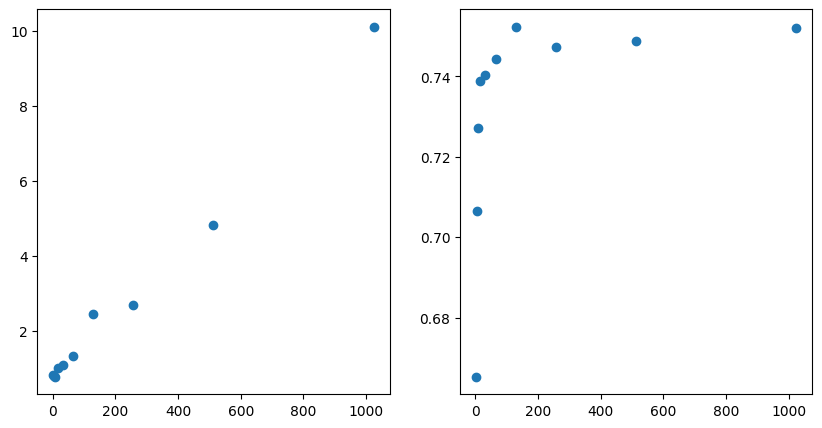

In [16]:
fig,ax=plt.subplots(1,2,figsize = (10,5))
ax[0].scatter( mb_list , time_list )
ax[1].scatter( mb_list , scores )

# XGBoost number of estimators, eta,  and validation

In [17]:
##let's start by splitting the data into a train and a validaiton set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_valid, y_train, y_valid = train_test_split(eye_features, labels , stratify=labels, random_state=94)

In [18]:
xgb_model = xgb.XGBClassifier(tree_method="hist", 
                        eval_metric = "auc", n_estimators=10)

xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)] )

[0]	validation_0-auc:0.85006	validation_1-auc:0.65095
[1]	validation_0-auc:0.88113	validation_1-auc:0.65875
[2]	validation_0-auc:0.91352	validation_1-auc:0.66436
[3]	validation_0-auc:0.92737	validation_1-auc:0.67970
[4]	validation_0-auc:0.93592	validation_1-auc:0.68336
[5]	validation_0-auc:0.94920	validation_1-auc:0.68871
[6]	validation_0-auc:0.95949	validation_1-auc:0.69670
[7]	validation_0-auc:0.96588	validation_1-auc:0.69447
[8]	validation_0-auc:0.97365	validation_1-auc:0.69470
[9]	validation_0-auc:0.97700	validation_1-auc:0.69350


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [19]:
xgb_model.evals_result_

{'validation_0': OrderedDict([('auc',
               [0.8500639798443382,
                0.8811321968767671,
                0.9135182088735552,
                0.9273675709513328,
                0.9359212968256522,
                0.949196947019981,
                0.9594945076729416,
                0.9658751164651401,
                0.9736473428298151,
                0.9769986010728835])]),
 'validation_1': OrderedDict([('auc',
               [0.6509459140534043,
                0.6587544912537548,
                0.6643643622001459,
                0.6796989049994434,
                0.6833571706725425,
                0.688710005262821,
                0.6966959944686625,
                0.6944672084087562,
                0.6947007157382947,
                0.6935019646277201])])}

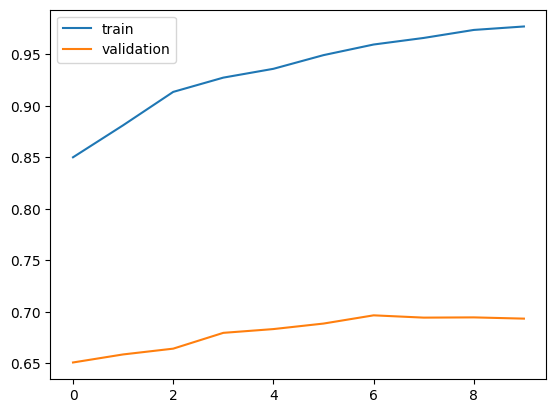

In [20]:
plt.plot( xgb_model.evals_result_['validation_0']['auc'] , label='train')
plt.plot( xgb_model.evals_result_['validation_1']['auc'] , label='validation')
plt.legend()

CPU times: user 3.68 s, sys: 11.8 ms, total: 3.69 s
Wall time: 636 ms


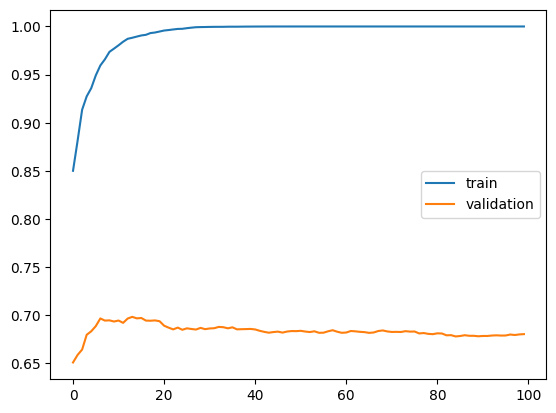

In [21]:
%%time
xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2,
    eta = 0.3 , n_estimators=100 , 
    eval_metric= 'auc' )

xgb_model.fit(X_train , y_train  , 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              verbose=False )
    
plt.plot( xgb_model.evals_result_['validation_0']['auc'] , label='train')
plt.plot( xgb_model.evals_result_['validation_1']['auc'] , label='validation')
plt.legend()

CPU times: user 4.62 s, sys: 23.4 ms, total: 4.64 s
Wall time: 780 ms


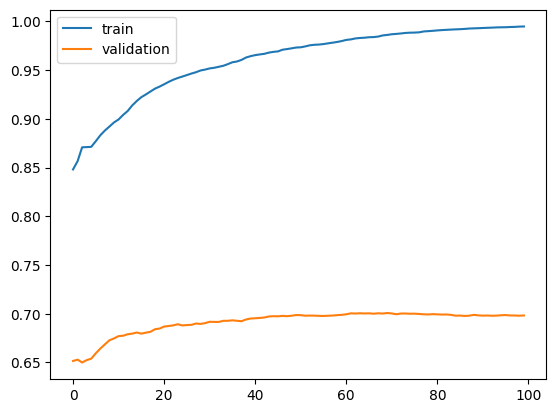

In [22]:
%%time
xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2,
    tree_method="hist" , eta = 0.05 , n_estimators=100 , 
    eval_metric= 'auc' )

xgb_model.fit(X_train , y_train  , 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              verbose=False )
    
plt.plot( xgb_model.evals_result_['validation_0']['auc'] , label='train')
plt.plot( xgb_model.evals_result_['validation_1']['auc'] , label='validation')
plt.legend()

CPU times: user 3.21 s, sys: 7.91 ms, total: 3.22 s
Wall time: 555 ms


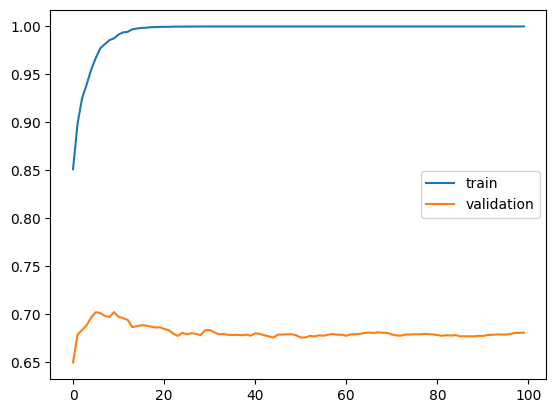

In [23]:
%%time
xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2,
    tree_method="hist" , eta = 0.5 , n_estimators=100 , 
    eval_metric= 'auc' )

xgb_model.fit(X_train , y_train  , 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              verbose=False )
    
plt.plot( xgb_model.evals_result_['validation_0']['auc'] , label='train')
plt.plot( xgb_model.evals_result_['validation_1']['auc'] , label='validation')
plt.legend()

In [24]:
## early stopping

clf = xgb.XGBClassifier(tree_method="hist", 
                        early_stopping_rounds=5 , 
                        eval_metric = "auc",
                        eta = 0.05 )
clf.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)])

[0]	validation_0-auc:0.84807	validation_1-auc:0.65148
[1]	validation_0-auc:0.85646	validation_1-auc:0.65286
[2]	validation_0-auc:0.87077	validation_1-auc:0.64995
[3]	validation_0-auc:0.87098	validation_1-auc:0.65237
[4]	validation_0-auc:0.87124	validation_1-auc:0.65386
[5]	validation_0-auc:0.87703	validation_1-auc:0.65938
[6]	validation_0-auc:0.88314	validation_1-auc:0.66423
[7]	validation_0-auc:0.88798	validation_1-auc:0.66854
[8]	validation_0-auc:0.89209	validation_1-auc:0.67274
[9]	validation_0-auc:0.89630	validation_1-auc:0.67466
[10]	validation_0-auc:0.89933	validation_1-auc:0.67699
[11]	validation_0-auc:0.90400	validation_1-auc:0.67741
[12]	validation_0-auc:0.90801	validation_1-auc:0.67892
[13]	validation_0-auc:0.91374	validation_1-auc:0.67956
[14]	validation_0-auc:0.91829	validation_1-auc:0.68071
[15]	validation_0-auc:0.92223	validation_1-auc:0.67954
[16]	validation_0-auc:0.92503	validation_1-auc:0.68055
[17]	validation_0-auc:0.92802	validation_1-auc:0.68144
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eta=0.05, eval_metric='auc',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [25]:
clf.best_iteration , clf.best_score #  These are used by the predict() 

(49, 0.6986438843928461)

Early stopping is great to balance the number of estimators and eta, but, as noted in the [XGBoost doc](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html#early-stopping):

"""
 However, using **early stopping during cross validation may not be a perfect approach because it changes the model’s number of trees for each validation fold, leading to different model.** A better approach is to retrain the model after cross validation using the best hyperparameters along with early stopping. If you want to experiment with idea of using cross validation with early stopping, here is a snippet to begin with:. However, using early stopping during cross validation may not be a perfect approach because it changes the model’s number of trees for each validation fold, leading to different model. A better approach is to retrain the model after cross validation using the best hyperparameters along with early stopping. 
 
 """


We can use it here to evaluate the effect of `eta`:

CPU times: user 1min 29s, sys: 212 ms, total: 1min 29s
Wall time: 15 s


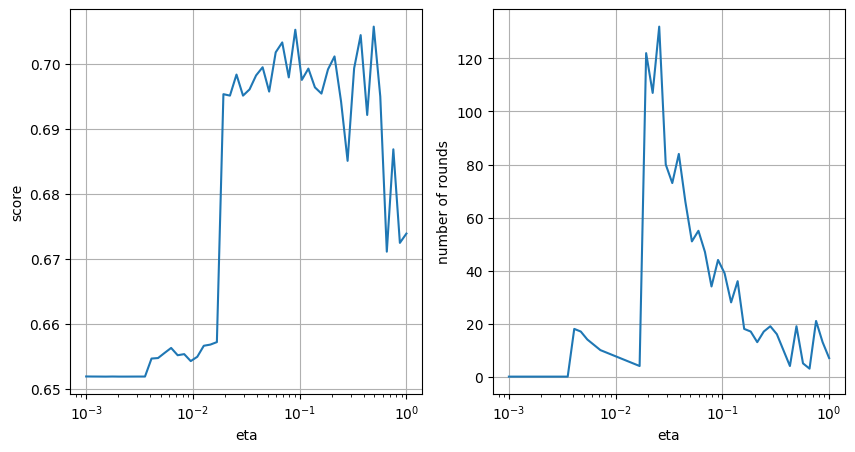

In [26]:
%%time
best_scores = []
num_rounds = []
etas = np.logspace(-3,0,50)
for eta in etas:
    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count()-2,
        early_stopping_rounds=10 ,
        eta = eta , n_estimators=500 , 
        eval_metric= 'auc' )

    xgb_model.fit(X_train , y_train  , 
                  eval_set=[(X_train, y_train),(X_valid, y_valid)],
                  verbose=False )

    best_scores.append( xgb_model.best_score )
    num_rounds.append( xgb_model.best_iteration )

fig,ax=plt.subplots(1,2,figsize = (10,5))
ax[0].plot( etas , best_scores )
ax[0].set_xlabel('eta')
ax[0].set_ylabel('score')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].plot( etas , num_rounds )
ax[1].set_xlabel('eta')
ax[1].set_ylabel('number of rounds')
ax[1].set_xscale('log')
ax[1].grid()


## exercise: 

Test the effect of the `subsample` parameter on XGboost

In [31]:
## tentative correction
# %load solutions/solution_xgb_subsample.py

# (some of) XGBoost hyper-parameters to control overfitting

from the [recommendations on controling overfitting from the documentation](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html#control-overfitting)



 * The first way is to directly control model complexity.
     * This includes `max_depth`, `min_child_weight` and `gamma`.

 * The second way is to add randomness to make training robust to noise.
     * This includes `subsample` and `colsample_bytree`.
     * You can also reduce stepsize `eta`. Remember to increase `num_round` when you do so.


We have already looked at `eta` and `subsample` together.


## max_depth

max_depth (Optional[int]) – Maximum tree depth for base learners.

In [32]:
# let's make a helper function to facilitate our work
def test_param( param_name, param_values, **kwargs ):

    best_scores_val = []
    best_scores_train = []
  
    for value in param_values:
        xgb_model = xgb.XGBClassifier(
            n_jobs=multiprocessing.cpu_count()-2,
            early_stopping_rounds=10 ,
            eval_metric= 'auc',
            **kwargs,
            **{param_name:value} 
        )

        xgb_model.fit(X_train , y_train  , 
                      eval_set=[(X_train, y_train),(X_valid, y_valid)],
                      verbose=False )

        best_scores_val.append( xgb_model.best_score )
        best_scores_train.append( xgb_model.evals_result_['validation_0']['auc'][xgb_model.best_iteration] )
        


    return param_values , best_scores_val , best_scores_train

In [34]:
eta=0.1
n_estimators = 100

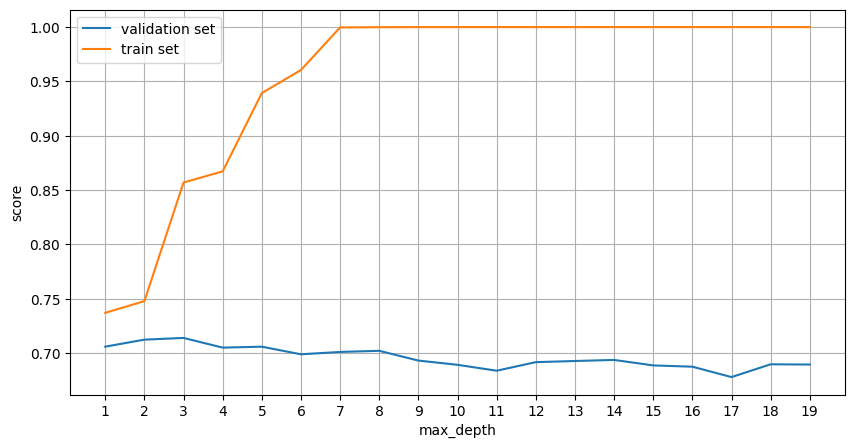

In [35]:
pname = 'max_depth'
pvals = np.arange(1,20)

param_values , best_scores_val , best_scores_train = test_param( pname, pvals , 
                                                                eta=eta , n_estimators=n_estimators)
fig,ax=plt.subplots(1,1,figsize = (10,5))
ax.plot( param_values , best_scores_val , label = 'validation set' )
ax.plot( param_values , best_scores_train , label = 'train set' )
ax.set_xticks( param_values )
ax.set_xlabel(pname)
ax.set_ylabel('score')
ax.grid()
ax.legend()

## gamma

gamma (Optional[float]) – (min_split_loss) Minimum loss reduction required to make a further partition on a leaf node of the tree.

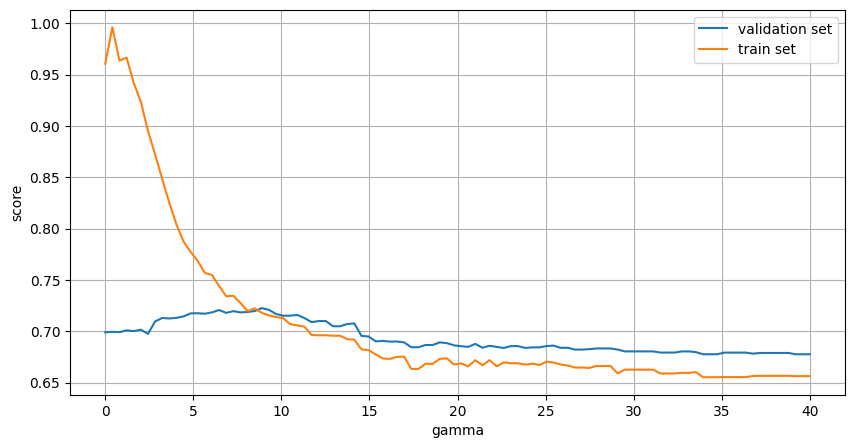

In [36]:
pname = 'gamma'
pvals = np.linspace(0.0,40,100)

param_values , best_scores_val , best_scores_train = test_param( pname, pvals,
                                                               eta=eta , n_estimators=n_estimators)
fig,ax=plt.subplots(1,1,figsize = (10,5))
ax.plot( param_values , best_scores_val , label = 'validation set' )
ax.plot( param_values , best_scores_train , label = 'train set' )
#ax.set_xticks( param_values )
ax.set_xlabel(pname)
ax.set_ylabel('score')
ax.grid()
ax.legend()

## min_child_weight

min_child_weight (Optional[float]) – Minimum sum of instance weight(hessian) needed in a child.

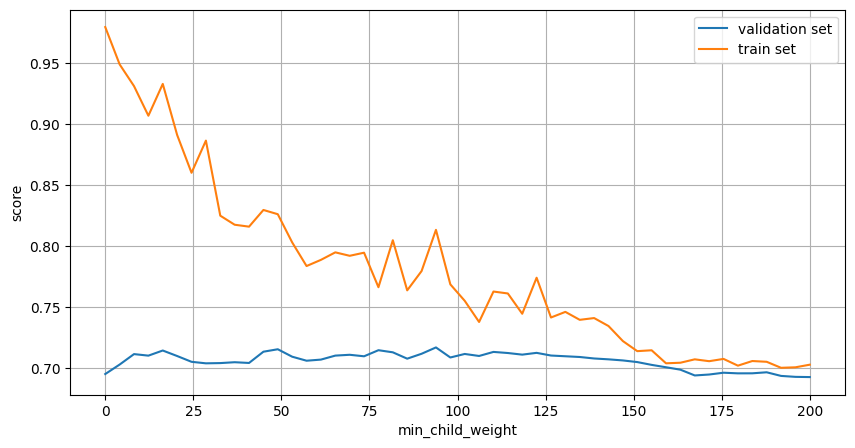

In [37]:
pname = 'min_child_weight'
pvals = np.linspace(0.0,200,50)

param_values , best_scores_val , best_scores_train = test_param( pname, pvals,
                                                               eta=eta , n_estimators=n_estimators)
fig,ax=plt.subplots(1,1,figsize = (10,5))
ax.plot( param_values , best_scores_val , label = 'validation set' )
ax.plot( param_values , best_scores_train , label = 'train set' )
#ax.set_xticks( param_values )
ax.set_xlabel(pname)
ax.set_ylabel('score')
ax.grid()
ax.legend()

## colsample_bytree

colsample_bytree (Optional[float]) – Subsample ratio of columns when constructing each tree.

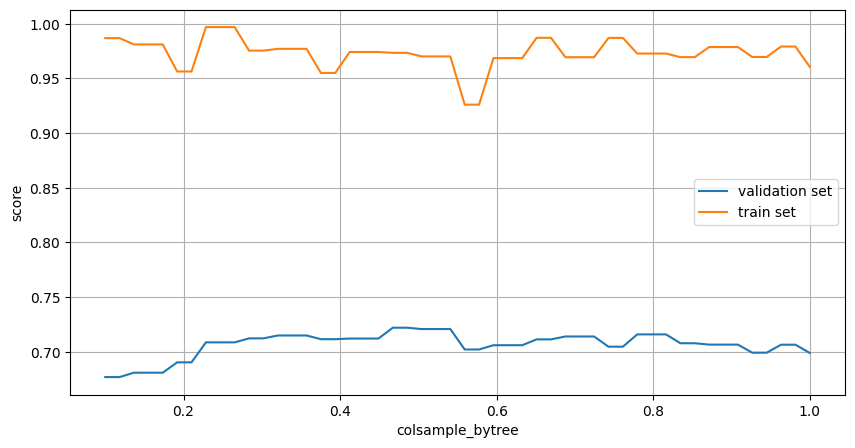

In [38]:
pname = 'colsample_bytree'
pvals = np.linspace(0.1,1.0,50)

param_values , best_scores_val , best_scores_train = test_param( pname, pvals ,
                                                               eta=eta , n_estimators=n_estimators)
fig,ax=plt.subplots(1,1,figsize = (10,5))
ax.plot( param_values , best_scores_val , label = 'validation set' )
ax.plot( param_values , best_scores_train , label = 'train set' )
#ax.set_xticks( param_values )
ax.set_xlabel(pname)
ax.set_ylabel('score')
ax.grid()
ax.legend()

And these are just some of the main hyper-parameters.

**micro-exercise:**
what may be missing from the hyper-parameter explorations we have done here?


<br>

<br>

<br>

---


# Annex : 

I put here some additional remarks and tricks

## Imbalance

https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html#handle-imbalanced-dataset

the documentation recommends to use `scale_pos_weight`, which corresponds to the re-weigthing of the positive calss samples

typical value num_negative_samples / num_positive_samples

Let's try it out:

In [39]:
from sklearn.datasets import make_classification

B = 0.99
X , y = make_classification(n_samples=3*10**3 , weights=[B,1-B])

Xt, Xv, yt, yv = train_test_split(X, y, stratify=y, random_state=89)

num_pos = yt.sum()

xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2, 
    early_stopping_rounds=10 ,
    eval_metric= 'auc',
    scale_pos_weight =  (len(yt) - num_pos) / num_pos )


xgb_model.fit(Xt , yt  , 
                  eval_set=[(Xt, yt),(Xv, yv)],
                  verbose=False )
print( xgb_model.best_score )

pd.crosstab( yv,  xgb_model.predict( Xv ) ,  rownames=['true'], colnames=['predicted'] )

0.7645099367660343


predicted,0,1
true,,
0,723,15
1,7,5


In [40]:
%%time

prop_zeros = np.logspace( np.log10(0.5) , np.log10(1-10**-3) , 50 )
auc_no_weights = []
auc_with_weights = []
recall_with_weight = []
recall_no_weight = []

for B in prop_zeros:
    X , y = make_classification(n_samples=3*10**3 , weights=[B,1-B])

    Xt, Xv, yt, yv = train_test_split(X, y, stratify=y, random_state=89)

    num_pos = yt.sum()

    ## with weights
    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count()-2, 
        early_stopping_rounds=10 ,
        eval_metric= 'auc',
        scale_pos_weight = (len(yt) - num_pos) / num_pos )


    xgb_model.fit(Xt , yt  , 
                      eval_set=[(Xt, yt),(Xv, yv)],
                      verbose=False )
    auc_with_weights.append( xgb_model.best_score )
    recall_with_weight.append( ( xgb_model.predict( Xv )[yv==1] ==1 ).mean() )
    ## without weights
    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count()-2, 
        early_stopping_rounds=10 ,
        eval_metric= 'auc')


    xgb_model.fit(Xt , yt  , 
                      eval_set=[(Xt, yt),(Xv, yv)],
                      verbose=False )
    auc_no_weights.append( xgb_model.best_score )
    
    recall_no_weight.append( ( xgb_model.predict( Xv )[yv==1] ==1 ).mean() )


CPU times: user 1min 10s, sys: 203 ms, total: 1min 10s
Wall time: 11.4 s


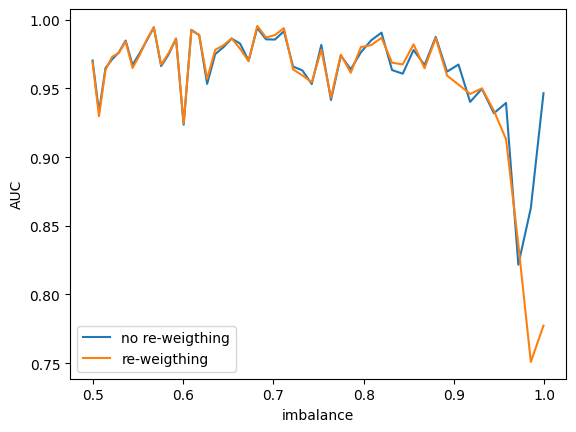

In [41]:
plt.plot( prop_zeros , auc_no_weights , label="no re-weigthing" )
plt.plot( prop_zeros , auc_with_weights , label="re-weigthing" )
plt.xlabel('imbalance')
plt.ylabel('AUC')
plt.legend()

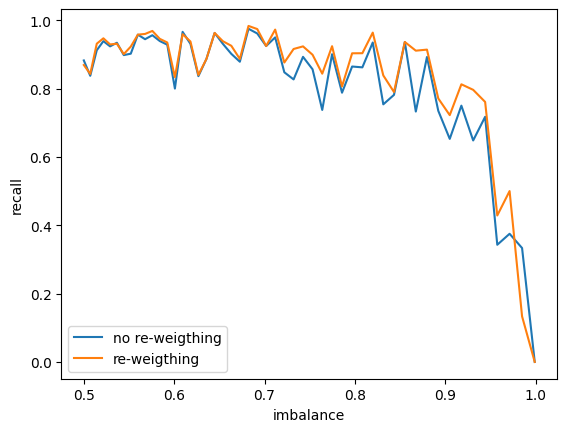

In [42]:
plt.plot( prop_zeros , recall_no_weight , label="no re-weigthing" )
plt.plot( prop_zeros , recall_with_weight , label="re-weigthing" )
plt.xlabel('imbalance')
plt.ylabel('recall')
plt.legend()

The effect is not extremely clear here, but recall tends to be better.

## trick: continuing training 

In [44]:
xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2,
    tree_method="hist" , eta = 0.3 , n_estimators=32  )

xgb_model.fit(X_train , y_train)

print( "first call to fit:", xgb_model.get_booster().num_boosted_rounds() , 'rounds')

xgb_model.fit(X_train , y_train  ,xgb_model=xgb_model )

print( "second call to fit:", xgb_model.get_booster().num_boosted_rounds() , 'rounds')

first call to fit: 32 rounds
second call to fit: 64 rounds
